In [11]:
# 載入所需套件
import math 
import tejapi
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import norm
plt.style.use('bmh')
plt.rcParams['font.sans-serif']=['Microsoft YaHei']

# 登入TEJ API
api_key = 'x0wxHZfmL3bbFbiuxaVRwDsPCHuudg'
tejapi.ApiConfig.api_key = api_key
tejapi.ApiConfig.ignoretz = True

gte, lte = '2021-03-16', '2023-04-10'
# 標的物價格
stocks = tejapi.get('TWN/APRCD',
                   paginate = True,
                   coid = 'Y9999',
                   mdate = {'gte':gte, 'lte':lte},
                   chinese_column_name = True,
                   opts = {
                       'columns':[ 'mdate','close_d']
                   }
                  )
# 選擇權價格
options = tejapi.get(
    'TWN/AOPTION',
    paginate = True,
    coid = 'TXO202304C15500',
    mdate = {'gte':gte, 'lte':lte},
    chinese_column_name = True,
    opts = {
        'columns':['mdate', 'coid','settle', 'kk', 'theoremp', 'acls', 'ex_price', 'td1y', 'avolt', 'rtime']
    }
)
# 重設日期為index
stocks = stocks.set_index('年月日')
options = options.set_index('日期')

stocks['日報酬'] = np.log(stocks['收盤價(元)']) - np.log(stocks['收盤價(元)'].shift(1))
stocks['移動報酬波動度'] = stocks['日報酬'].rolling(252).std()

ForbiddenError: (Status 400) (Tej Error PDB003) 您沒有存取資料表的權限。

In [12]:
stocks =pd.read_csv("D:/history.csv")
stocks = stocks.set_index('date')

# options = options.set_index('日期')
stocks
stocks['日報酬'] = np.log(stocks['close']) - np.log(stocks['close'].shift(1))
stocks['移動報酬波動度'] = stocks['日報酬'].rolling(252).std()
stocks

,open,high,low,close,日報酬,移動報酬波動度
date,,,,,,
2010/01/04,8222.42,8240.45,8143.45,8207.85,NaN,NaN
2010/01/05,8277.71,8283.64,8162.54,8211.40,0.000432,NaN
2010/01/06,8237.10,8327.87,8216.92,8327.62,0.014054,NaN
2010/01/07,8344.56,8369.55,8233.59,8237.42,-0.010891,NaN
2010/01/08,8266.87,8290.66,8178.93,8280.90,0.005264,NaN
...,...,...,...,...,...,...
2022/12/26,14271.20,14301.11,14253.20,14285.13,0.000945,0.012463
2022/12/27,14310.19,14410.24,14310.19,14328.43,0.003027,0.012465
2022/12/28,14249.83,14249.83,14119.30,14173.10,-0.010900,0.012473


In [47]:
pd.DataFrame(stocks['close'] - stocks['close'].shift(1)).to_csv('D:/diff.csv')

In [25]:
stocks['close']

date
2010/01/04     8207.85
2010/01/05     8211.40
2010/01/06     8327.62
2010/01/07     8237.42
2010/01/08     8280.90
                ...   
2022/12/26    14285.13
2022/12/27    14328.43
2022/12/28    14173.10
2022/12/29    14085.02
2022/12/30    14137.69
Name: close, Length: 3200, dtype: float64

In [13]:
class BS_formula:

    def __init__(self, s0, k, r, sigma, T):     
        self.s0 = s0 # 標的物價格
        self.k = k # 履約價格
        self.r = r # 無風險利率
        self.sigma = sigma # 歷史波動度
        self.T = T # 剩餘到期時間
        self.d1 = (np.log(s0/k)+(r+sigma**2/2)*T) / (sigma * np.sqrt(T))
        self.d2 = ((np.log(s0/k)+(r+sigma**2/2)*T) / (sigma * np.sqrt(T))) - sigma*np.sqrt(T)
        
    def BS_price(self): # 計算理論價格
        c = self.s0*norm.cdf(self.d1) - self.k*np.exp(-self.r*self.T)*norm.cdf(self.d2)
        p = self.k*np.exp(-self.r*self.T)*norm.cdf(-self.d2) - self.s0*norm.cdf(-self.d1)
        return c,p
        
    def BS_delta(self): # 計算 delta
        return norm.cdf(self.d1), norm.cdf(self.d1)-1
    
    def BS_gamma(self): # 計算 gamma
        return norm.pdf(self.d1)/(self.s0*self.sigma*np.sqrt(self.T)), norm.pdf(self.d1)/(self.s0*self.sigma*np.sqrt(self.T))
    
    def BS_vega(self): # 計算 vega
        return self.s0*np.sqrt(self.T)*norm.pdf(self.d1), self.s0*np.sqrt(self.T)*norm.pdf(self.d1)
    
    def BS_theta(self): # 計算 theta 
        c_theta = -self.s0*norm.pdf(self.d1)*self.sigma / (2*np.sqrt(self.T)) - self.r*self.k*np.exp(-self.r*self.T)*norm.cdf(self.d2)
        p_theta = -self.s0*norm.pdf(self.d1)*self.sigma / (2*np.sqrt(self.T)) + self.r*self.k*np.exp(-self.r*self.T)*norm.cdf(-self.d2)
        return c_theta, p_theta
    
    def BS_rho(self): # 計算 rho  
        return self.k*self.T*np.exp(-self.r*self.T)*norm.cdf(self.d2), -self.k*self.T*np.exp(-self.r*self.T)*norm.cdf(-self.d2)

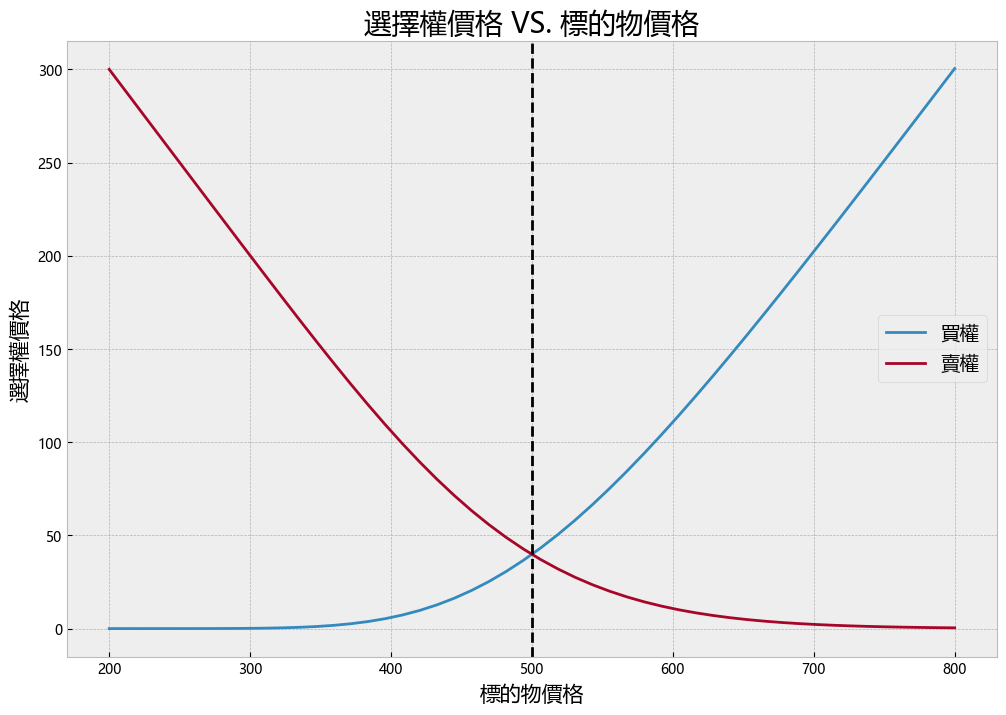

In [14]:
s0 = np.linspace(200,800)
k = 500
r = 0.00
sigma = 0.2
T = 252/252

mybs = BS_formula(s0, k, r, sigma, T)
c, p = mybs.BS_price()

fig = plt.figure(figsize = (12,8))
plt.plot(s0, c, label = '買權')
plt.plot(s0, p, label = '賣權')
plt.axvline(x = 500, color = 'black', linestyle = '--')
plt.xlabel('標的物價格', fontsize = 15)
plt.ylabel('選擇權價格', fontsize = 15)
plt.title('選擇權價格 VS. 標的物價格', fontsize = 20)
plt.legend(fontsize = 14)
plt.savefig('black scholes put call price.png')
plt.show()

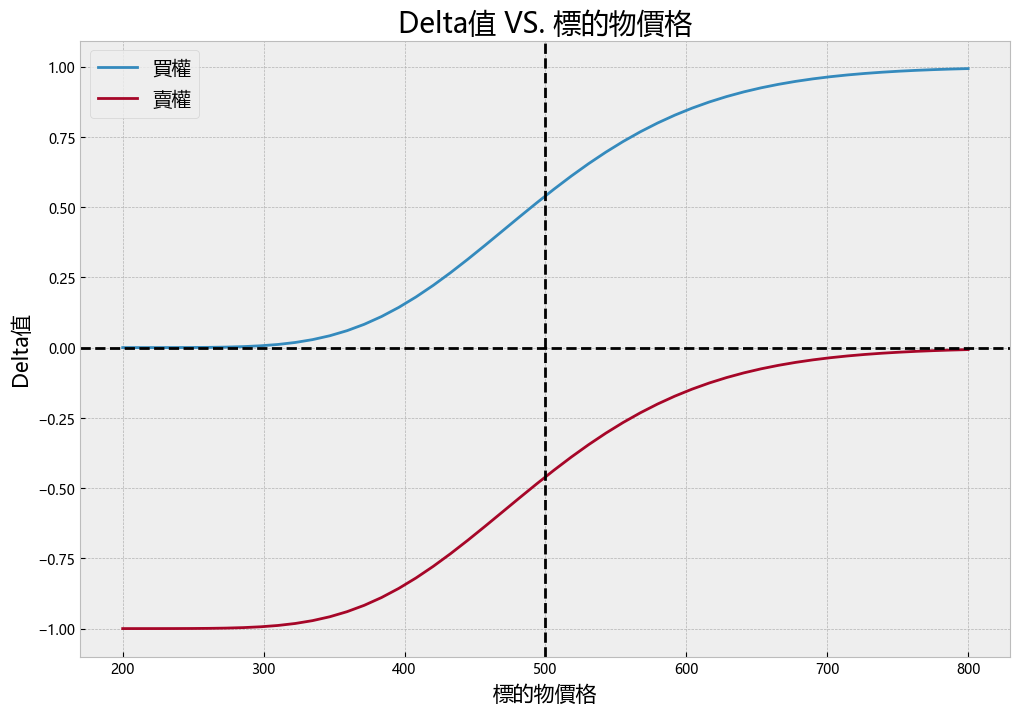

In [15]:
s0 = np.linspace(200,800)
k = 500
r = 0.00
sigma = 0.2
T = 252/252

mybs = BS_formula(s0, k, r, sigma, T)
c, p = mybs.BS_delta()

fig = plt.figure(figsize = (12,8))
plt.plot(s0, c, label = '買權')
plt.plot(s0, p, label = '賣權')
plt.axvline(x = 500, color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.xlabel('標的物價格', fontsize = 15)
plt.ylabel('Delta值', fontsize = 15)
plt.title('Delta值 VS. 標的物價格', fontsize = 20)
plt.legend(fontsize = 14)
plt.savefig('black scholes put call delta.png')
plt.show()

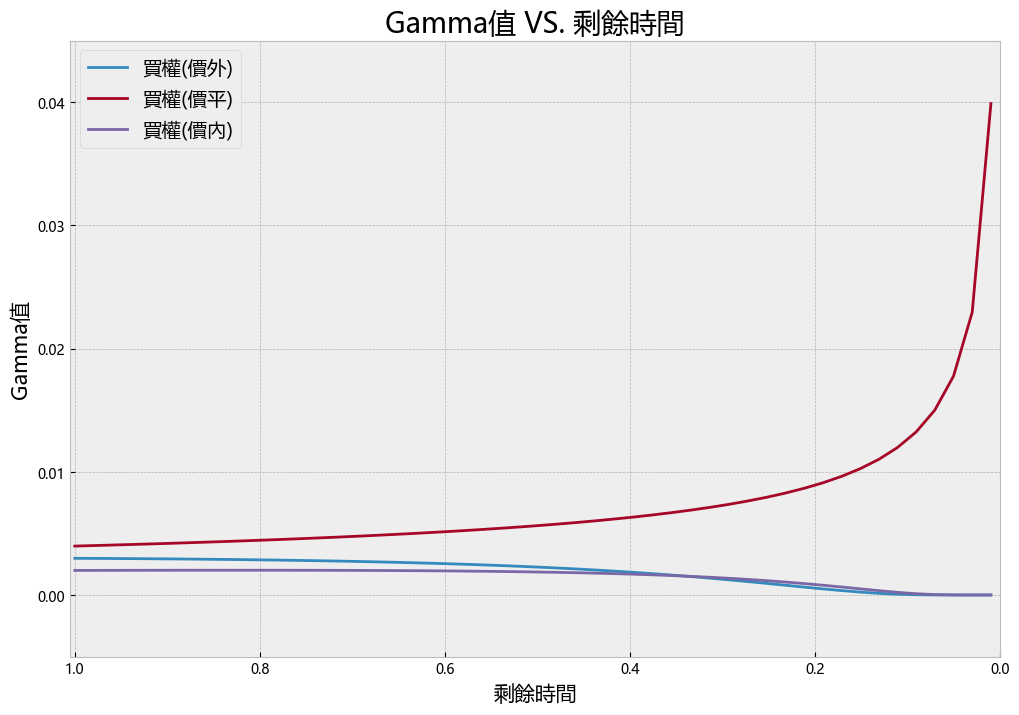

In [16]:
s0, s1, s2 = 400, 500, 600 
k = 500
r = 0.00
sigma = 0.2
T = np.linspace(1, 0.01)

mybs0 = BS_formula(s0, k, r, sigma, T)
c0, p0 = mybs0.BS_gamma()

mybs1 = BS_formula(s1, k, r, sigma, T)
c1, p1 = mybs1.BS_gamma()

mybs2 = BS_formula(s2, k, r, sigma, T)
c2, p2 = mybs2.BS_gamma()

fig = plt.figure(figsize = (12,8))
plt.plot(T, c0, label = '買權(價外)')
plt.plot(T, c1, label = '買權(價平)')
plt.plot(T, c2, label = '買權(價內)')
plt.xlabel('剩餘時間', fontsize = 15)
plt.ylabel('Gamma值', fontsize = 15)
plt.title('Gamma值 VS. 剩餘時間', fontsize = 20)
plt.legend(fontsize = 14)
plt.axis([1.005, -0, -0.005, .045])
plt.savefig('black scholes put call gamma2.png')
plt.show()

In [44]:
r = 0.012
s0 = stocks.loc[stocks.index == '2022/12/30','close']
k = 15500
sigma = stocks.loc[stocks.index == '2022/12/30','移動報酬波動度']*np.sqrt(252)
# sigma = stocks['移動報酬波動度']*np.sqrt(252)
T = 6/252

mybs = BS_formula(s0, k, r, sigma, T)
c, p = mybs.BS_price()
c_delta, p_delta = mybs.BS_delta()
c_gamma, p_gamma = mybs.BS_gamma()
c_vega, p_vega = mybs.BS_vega()
c_theta, p_theta = mybs.BS_theta()
c_rho, p_rho = mybs.BS_rho()

print('==2023-04-10履約價為525的台積電買權==')
print('當前標的物價格為 %.3f， 年化波動度為 %.3f， 剩餘期間為 %.3f'%(s0, sigma, T*252))
print('買權理論價格: %.4f， 賣權理論價格: %.4f' %(c,p))
print('買權delta: %.4f， 賣權delta: %.4f' %(c_delta,p_delta))
print('買權gamma: %.4f， 賣權gamma: %.4f' %(c_gamma,p_gamma))
print('買權vega: %.4f， 賣權vega: %.4f' %(c_vega,p_vega))
print('買權theta: %.4f， 賣權theta: %.4f' %(c_theta,p_theta))
print('買權rho: %.4f， 賣權rho: %.4f' %(c_rho,p_rho))

==2023-04-10履約價為525的台積電買權==
當前標的物價格為 14137.690， 年化波動度為 0.198， 剩餘期間為 6.000
買權理論價格: 0.1712， 賣權理論價格: 1358.0533
買權delta: 0.0014， 賣權delta: -0.9986
買權gamma: 0.0000， 賣權gamma: 0.0000
買權vega: 10.0455， 賣權vega: 10.0455
買權theta: -41.9958， 賣權theta: 143.9511
買權rho: 0.4698， 賣權rho: -368.4724


C:\Users\sulab\AppData\Local\Temp\ipykernel_20496\1301909313.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('當前標的物價格為 %.3f， 年化波動度為 %.3f， 剩餘期間為 %.3f'%(s0, sigma, T*252))
C:\Users\sulab\AppData\Local\Temp\ipykernel_20496\1301909313.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('買權理論價格: %.4f， 賣權理論價格: %.4f' %(c,p))
C:\Users\sulab\AppData\Local\Temp\ipykernel_20496\1301909313.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('買權delta: %.4f， 賣權delta: %.4f' %(c_delta,p_delta))
C:\Users\sulab\AppData\Local\Temp\ipykernel_20496\1301909313.py:20: FutureWarning: Calling float on a single element

In [35]:
options.loc['2023-04-10'] # 實際買權價格

NameError: name 'options' is not defined